行列の固有値分布を変えたときに，DE公式で計算するときにどれだけの刻み幅でどれだけの標本点数が必要になるか調べる．  
その後，その刻み幅・標本点数のときの誤差を調べて，標本点数に対する誤差をプロットする．  
これにより，固有値分布によってどれだけの標本点数が必要になってくるか調べる．  
行列符号関数をDE公式で計算する場合，1つの標本点に対して逆行列の計算(約 $n^3$ のオーダー)をする必要があり必要標本点数が計算時間を見積もるために重要であると考えられる．

In [2]:
#固有値分布を変えて収束性がどのように変わるか調べる
import numpy as np 
import scipy as sp
import matplotlib.pyplot as plt  
import sign_de_class
import pandas as pd 
import matrix_cls
markers1 = [".", ",", "o", "v", "^", "<", ">", "1", "2", "3"]


In [3]:
#全無限区間用はクラスなどを作成していないので特別に用意

def integrand_sinh(x, I, A2):
    return np.linalg.inv(x**2*I + A2)

#この関数とtransform_difが全無限区間の場合違う exp() -> sinh() 中身は同じ
def transform(x):
    return np.sinh(np.pi*0.5*np.sinh(x))
    
def transform_dif(x):
    return np.pi*0.5*np.cosh(np.pi*0.5*np.sinh(x))*np.cosh(x)

def de_formula_sinh(h, I, A, A2):
    #sは部分和の合計，これに足し合わせていく
    s = integrand_sinh(transform(0.0), I, A2)*transform_dif(0.0)
    maxn = 10000
    eps = 1e-15
    npm = [maxn, maxn]
    for i in range(1, maxn+1):
        x = i*h 
        t = integrand_sinh(transform(x), I, A2)*transform_dif(x)
        s += t
        #tmpでtのフロベニウスノルムを計算し，それがeps以下になったら反復を終了する
        tmp = np.linalg.norm(t, 'fro')
        if tmp < eps:
            npm[0] = i 
            break
    for i in range(1, maxn+1):
        x = -i*h 
        t = integrand_sinh(transform(x), I, A2)*transform_dif(x)
        s += t
        #tmpでtのフロベニウスノルムを計算し，それがeps以下になったら反復を終了する
        tmp = np.linalg.norm(t, 'fro')
        if tmp < eps:
            npm[1] = i 
            break
    ans = A@s/np.pi*h
    return ans, npm, npm[0]+npm[1]+1

def solve_step_sinh(step_num, def_ans, I, A, A2, h = 0.5, h_delta = 0.5):
    #print(f"test Aeig: {np.linalg.eig(A)[0]}")
    """
    この関数で，刻み幅hについて収束するまで標本点を増やして計算する
    hをstep_n回変えていき，上記のことを行う

    刻み幅h, 標本点数(正，負，合計)のタプル，誤差
    をstep_num個分もった配列を返す

    h: 初期刻み幅
    h_delta: hを減らしてくときにどれだけの倍率で減らすか．
    """
    #h=0.125 引数に追加するようにした
    #ret_values: リスト. これに要素を追加していく
    ret_values = []

    ans, npm, nall = de_formula_sinh(h, I, A, A2)
    dif = np.linalg.norm(ans-def_ans, "fro")
    ret_values.append([h, (npm[0], npm[1], nall), dif])
    #npmを足し合わせていきたいので最初はループ外
    for _ in range(step_num-1):
        h*= h_delta
        ans, npm, nall = de_formula_sinh(h, I, A, A2)
        dif = np.linalg.norm(ans-def_ans, "fro")
        ret_values.append([h, (npm[0], npm[1], nall), dif])
    return ret_values



In [4]:
#正の固有値のみ 最大，最小固有値を変える
#最小固有値0.1に固定 最大固有値を変えていく (1e+1, 1e+2, ...,1e+6)
#無限区間

size = 100
rec = 5


endpoint = 1
emin = 0.1

mat_cls = matrix_cls.Make_matrix2(size=size, mattype="normal")
step_num = 10

#rec回分の標本点数と誤差がstep_num回分入った配列
#data_pos_exp = np.zeros((rec, 2, step_num))
data_pos_sinh = np.zeros((rec, 2, step_num))

x_rng = np.random.default_rng(1)
X = x_rng.random((size, size))
Xinv = np.linalg.inv(X)

I = np.eye(size)
for i in range(rec):
    #最小固有値は0.1, 最大固有値は10^endpoint
    emax = 10**endpoint
    a = np.zeros((size, size))
    a[0, 0] = emax 
    a[1, 1] = emin 
    a_rng = np.random.default_rng(i+50)
    for j in range(size - 2):
        a[j+2, j+2] = (emax - emin)*a_rng.random() + emin 
    
    A = X@a@Xinv
    A2 = A@A 
    sign_de = sign_de_class.DEformula_calculator(A)
    def_ans = sign_de.solve_ans()
    #points_exp = sign_de.solve_step(step_num=step_num, def_ans=def_ans, h=0.5, method="1", h_delta=0.8)
    points_sinh = solve_step_sinh(step_num, def_ans, I, A, A2, h=0.1, h_delta=0.75)
    #data_pos_exp[i, 0] = np.array([l[1][-1] for l in points_exp])
    #data_pos_exp[i, 1] = np.array([l[-1] for l in points_exp])
    data_pos_sinh[i, 0] = np.array([l[1][-1] for l in points_sinh])
    data_pos_sinh[i, 1] = np.array([l[-1] for l in points_sinh])
    #print([l[1][:] for l in points])
    endpoint +=1

#np.save("data/np_save/data_pos_exp", data_pos_exp)
#np.save("data/np_save/data_pos_sinh", data_pos_sinh)



In [14]:
#正の固有値のみ 最大，最小固有値を変える
#最小固有値0.1に固定 最大固有値を変えていく (1e+1, 1e+2, ...,1e+6)
#半無限区間

size = 100
rec = 5


endpoint = 1
emin = 0.1

mat_cls = matrix_cls.Make_matrix2(size=size, mattype="normal")
step_num = 15

#rec回分の標本点数と誤差がstep_num回分入った配列
data_pos_exp = np.zeros((rec, 2, step_num))
#data_pos_sinh = np.zeros((rec, 2, step_num))

x_rng = np.random.default_rng(1)
X = x_rng.random((size, size))
Xinv = np.linalg.inv(X)

I = np.eye(size)
for i in range(rec):
    #最小固有値は0.1, 最大固有値は10^endpoint
    emax = 10**endpoint
    a = np.zeros((size, size))
    a[0, 0] = emax 
    a[1, 1] = emin 
    a_rng = np.random.default_rng(i+50)
    for j in range(size - 2):
        a[j+2, j+2] = (emax - emin)*a_rng.random() + emin 
    
    A = X@a@Xinv
    A2 = A@A 
    sign_de = sign_de_class.DEformula_calculator(A)
    def_ans = sign_de.solve_ans()
    points_exp = sign_de.solve_step(step_num=step_num, def_ans=def_ans, h=0.5, method="1", h_delta=0.8)
    #points_sinh = solve_step_sinh(step_num, def_ans, I, A, A2, h=0.1, h_delta=0.75)
    data_pos_exp[i, 0] = np.array([l[1][-1] for l in points_exp])
    data_pos_exp[i, 1] = np.array([l[-1] for l in points_exp])
    #data_pos_sinh[i, 0] = np.array([l[1][-1] for l in points_sinh])
    #data_pos_sinh[i, 1] = np.array([l[-1] for l in points_sinh])
    #print([l[1][:] for l in points])
    endpoint +=1

#np.save("data/np_save/data_pos_exp", data_pos_exp)
#np.save("data/np_save/data_pos_sinh", data_pos_sinh)

In [3]:
#npy形式で保存されたnumpy配列のファイルを読み込む 保存はnp.save, 読み込みはnp.load
data_pos_exp = np.load("data/np_save/data_pos_exp.npy")
data_pos_sinh = np.load("data/np_save/data_pos_sinh.npy")

In [5]:
from sklearn.linear_model import LinearRegression

#x軸通常，y軸対数の場合について線形回帰をsklearnの関数を用いて行う
#返り値としてはモデルのインスタンスを返すようにして，受け取った方でそこからcoefなどのインスタンス変数を読み出す
def forcoef3(data_x, data_y):
    model = LinearRegression()
    model.fit(data_x.reshape(-1, 1), np.log10(data_y))
    return model

[0.1, 10]: [-0.12786959], [0.1, 100]: [-0.10587877], [0.1, 1000]: [-0.07660301], [0.1, 10000]: [-0.05814505]


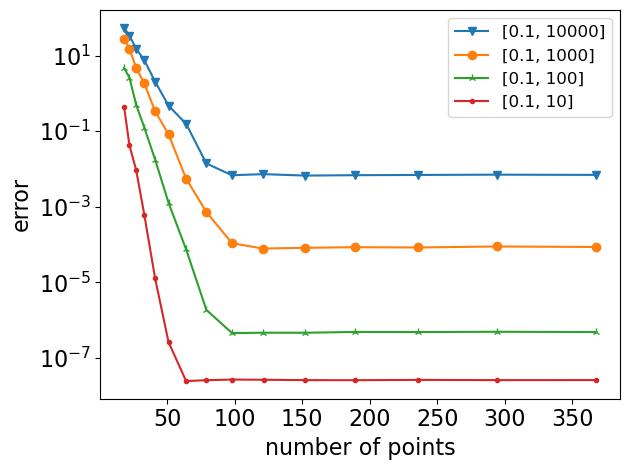

In [15]:
data_exp = data_pos_exp
data_sinh = data_pos_sinh
figure, ax = plt.subplots()
#markers1 = [".", ",", "o", "v", "^", "<", ">", "1", "2", "3"]
#plt.rcParams["font.size"] = 18
#plt.rcParams['font.family'] = 'Times New Roman'
plt.plot(data_exp[3, 0], data_exp[3,1], marker=markers1[3],label="[0.1, 10000]")
plt.plot(data_exp[2, 0], data_exp[2,1], marker=markers1[2],label="[0.1, 1000]")
plt.plot(data_exp[1, 0], data_exp[1,1], marker=markers1[-2],label="[0.1, 100]")
plt.plot(data_exp[0, 0], data_exp[0,1], marker=markers1[0],label="[0.1, 10]")

model1 = forcoef3(data_exp[0, 0][:8], data_exp[ 0, 1][:8])
model2 = forcoef3(data_exp[1, 0][:8], data_exp[ 1, 1][:8])
model3 = forcoef3(data_exp[2, 0][:8], data_exp[ 2, 1][:8])
model4 = forcoef3(data_exp[3, 0][:8], data_exp[ 3, 1][:8])
print(f"[0.1, 10]: {model1.coef_}, [0.1, 100]: {model2.coef_}, [0.1, 1000]: {model3.coef_}, [0.1, 10000]: {model4.coef_}")

#ax.plot(data[4, 0], data[4,1], marker=markers1[4],label="[0.1, 1e+5]")
#ax.plot(data[5, 0], data[5,1], marker=markers1[5],label="[0.1, 1e+6]")

#plt.set_xlabel("number of points")
#plt.set_ylabel("error")
plt.xlabel("number of points", fontsize = 16)
plt.ylabel("error", fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 12)
#ax.set_yscale("log")
plt.yscale("log")
plt.tight_layout()
#plt.savefig("thesis_data/pos_real_exp.eps", dpi=300)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


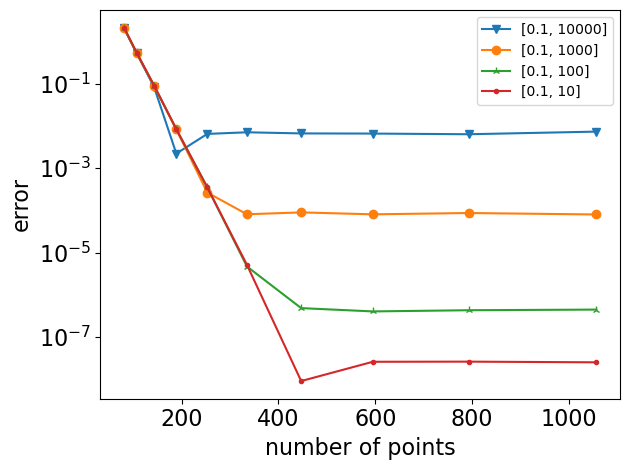

In [9]:
data_exp = data_pos_exp
data_sinh = data_pos_sinh
figure, ax = plt.subplots()

ax.plot(data_sinh[3, 0], data_sinh[3,1], marker=markers1[3],label="[0.1, 10000]")
ax.plot(data_sinh[2, 0], data_sinh[2,1], marker=markers1[2],label="[0.1, 1000]")
ax.plot(data_sinh[1, 0], data_sinh[1,1], marker=markers1[-2],label="[0.1, 100]")
ax.plot(data_sinh[0, 0], data_sinh[0,1], marker=markers1[0],label="[0.1, 10]")


ax.set_xlabel("number of points", fontsize=16)
ax.set_ylabel("error", fontsize=16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

ax.legend()
ax.set_yscale("log")
plt.tight_layout()
plt.savefig("thesis_data/pos_real_sinh.eps", dpi=300)
plt.show()

In [16]:
#正の固有値のみ 最大，最小固有値を変える
#最小固有値0.1に固定 最大固有値を変えていく (1e+1, 1e+2, ...,1e+6)
#半無限区間

size = 100
rec = 5


endpoint = 1
emax = 10

mat_cls = matrix_cls.Make_matrix2(size=size, mattype="normal")
step_num = 15

#rec回分の標本点数と誤差がstep_num回分入った配列
data_pos_exp = np.zeros((rec, 2, step_num))
#data_pos_sinh = np.zeros((rec, 2, step_num))

x_rng = np.random.default_rng(1)
X = x_rng.random((size, size))
Xinv = np.linalg.inv(X)

I = np.eye(size)
for i in range(rec):
    #最大固有値は10, 最小固有値は10^(-endpoint)
    emin = 10**(-endpoint)
    a = np.zeros((size, size))
    a[0, 0] = emax 
    a[1, 1] = emin 
    a_rng = np.random.default_rng(i+20)
    for j in range(size - 2):
        a[j+2, j+2] = (emax - emin)*a_rng.random() + emin 
    
    A = X@a@Xinv
    A2 = A@A 
    sign_de = sign_de_class.DEformula_calculator(A)
    def_ans = sign_de.solve_ans()
    points_exp = sign_de.solve_step(step_num=step_num, def_ans=def_ans, h=0.5, method="1", h_delta=0.8)
    #points_sinh = solve_step_sinh(step_num, def_ans, I, A, A2, h=0.1, h_delta=0.75)
    data_pos_exp[i, 0] = np.array([l[1][-1] for l in points_exp])
    data_pos_exp[i, 1] = np.array([l[-1] for l in points_exp])
    #data_pos_sinh[i, 0] = np.array([l[1][-1] for l in points_sinh])
    #data_pos_sinh[i, 1] = np.array([l[-1] for l in points_sinh])
    #print([l[1][:] for l in points])
    endpoint +=1

#np.save("data/np_save/data_pos_exp", data_pos_exp)
#np.save("data/np_save/data_pos_sinh", data_pos_sinh)

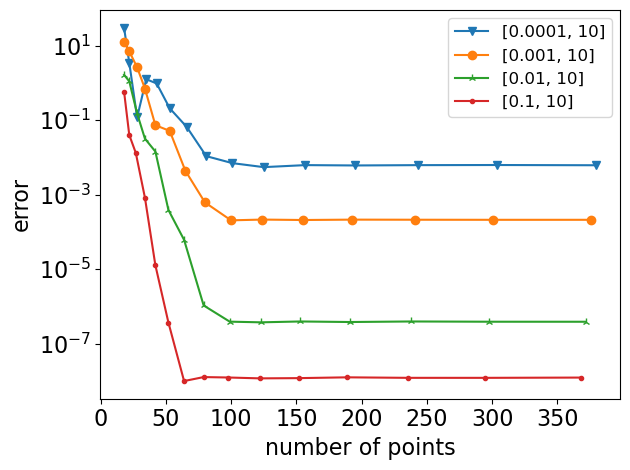

In [17]:
data_exp = data_pos_exp
#data_sinh = data_pos_sinh
figure, ax = plt.subplots()
markers1 = [".", ",", "o", "v", "^", "<", ">", "1", "2", "3"]
#plt.rcParams["font.size"] = 18
#plt.rcParams['font.family'] = 'Times New Roman'
plt.plot(data_exp[3, 0], data_exp[3,1], marker=markers1[3],label="[0.0001, 10]")
plt.plot(data_exp[2, 0], data_exp[2,1], marker=markers1[2],label="[0.001, 10]")
plt.plot(data_exp[1, 0], data_exp[1,1], marker=markers1[-2],label="[0.01, 10]")
plt.plot(data_exp[0, 0], data_exp[0,1], marker=markers1[0],label="[0.1, 10]")

"""
model1 = forcoef3(data_exp[0, 0][:8], data_exp[ 0, 1][:8])
model2 = forcoef3(data_exp[1, 0][:8], data_exp[ 1, 1][:8])
model3 = forcoef3(data_exp[2, 0][:8], data_exp[ 2, 1][:8])
model4 = forcoef3(data_exp[3, 0][:8], data_exp[ 3, 1][:8])
print(f"[0.1, 10]: {model1.coef_}, [0.1, 100]: {model2.coef_}, [0.1, 1000]: {model3.coef_}, [0.1, 10000]: {model4.coef_}")
"""
#ax.plot(data[4, 0], data[4,1], marker=markers1[4],label="[0.1, 1e+5]")
#ax.plot(data[5, 0], data[5,1], marker=markers1[5],label="[0.1, 1e+6]")

#plt.set_xlabel("number of points")
#plt.set_ylabel("error")
plt.xlabel("number of points", fontsize = 16)
plt.ylabel("error", fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 12)
#ax.set_yscale("log")
plt.yscale("log")
plt.tight_layout()
#plt.savefig("thesis_data/pos_real_exp_max10.eps", dpi=300)
plt.show()

In [18]:
#正の固有値のみ 最大，最小固有値を変える
#最小固有値0.1に固定 最大固有値を変えていく (1e+1, 1e+2, ...,1e+6)
#無限区間

size = 100
rec = 5


endpoint = 1
emax = 10

mat_cls = matrix_cls.Make_matrix2(size=size, mattype="normal")
step_num = 10

#rec回分の標本点数と誤差がstep_num回分入った配列
#data_pos_exp = np.zeros((rec, 2, step_num))
data_pos_sinh = np.zeros((rec, 2, step_num))

x_rng = np.random.default_rng(1)
X = x_rng.random((size, size))
Xinv = np.linalg.inv(X)

I = np.eye(size)
for i in range(rec):
    #最大固有値は10, 最小固有値は10^(-endpoint)
    emin = 10**(-endpoint)
    a = np.zeros((size, size))
    a[0, 0] = emax 
    a[1, 1] = emin 
    a_rng = np.random.default_rng(i+20)
    for j in range(size - 2):
        a[j+2, j+2] = (emax - emin)*a_rng.random() + emin 
    
    A = X@a@Xinv
    A2 = A@A 
    sign_de = sign_de_class.DEformula_calculator(A)
    def_ans = sign_de.solve_ans()
    #points_exp = sign_de.solve_step(step_num=step_num, def_ans=def_ans, h=0.5, method="1", h_delta=0.8)
    points_sinh = solve_step_sinh(step_num, def_ans, I, A, A2, h=0.1, h_delta=0.75)
    #data_pos_exp[i, 0] = np.array([l[1][-1] for l in points_exp])
    #data_pos_exp[i, 1] = np.array([l[-1] for l in points_exp])
    data_pos_sinh[i, 0] = np.array([l[1][-1] for l in points_sinh])
    data_pos_sinh[i, 1] = np.array([l[-1] for l in points_sinh])
    #print([l[1][:] for l in points])
    endpoint +=1

#np.save("data/np_save/data_pos_exp", data_pos_exp)
#np.save("data/np_save/data_pos_sinh", data_pos_sinh)

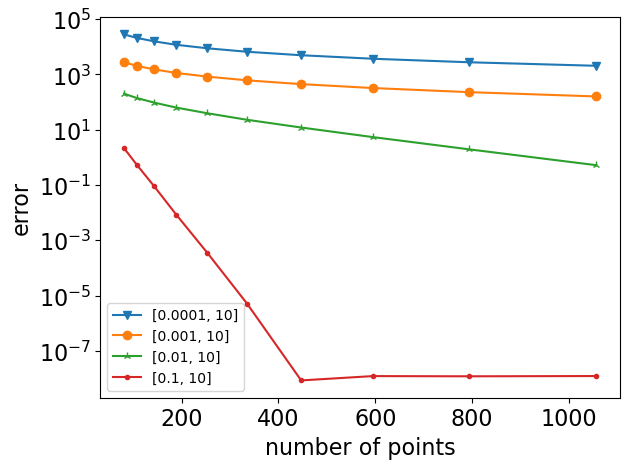

In [19]:
#data_exp = data_pos_exp
data_sinh = data_pos_sinh
figure, ax = plt.subplots()

ax.plot(data_sinh[3, 0], data_sinh[3,1], marker=markers1[3],label="[0.0001, 10]")
ax.plot(data_sinh[2, 0], data_sinh[2,1], marker=markers1[2],label="[0.001, 10]")
ax.plot(data_sinh[1, 0], data_sinh[1,1], marker=markers1[-2],label="[0.01, 10]")
ax.plot(data_sinh[0, 0], data_sinh[0,1], marker=markers1[0],label="[0.1, 10]")


ax.set_xlabel("number of points", fontsize=16)
ax.set_ylabel("error", fontsize=16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

ax.legend()
ax.set_yscale("log")
plt.tight_layout()
#plt.savefig("thesis_data/pos_real_sinh_max10.eps", dpi=300)
plt.show()

以上より，正で実数の固有値を含む場合は半無限区間の積分についてDE公式を適用した方が少ない標本点数で計算できることがわかった．  
次に，負の固有値を含む場合について半無限区間の場合のみ調べる．


In [20]:
#負の固有値を含む
#最小固有値0.1に固定 最大固有値を変えていく (1e+1, 1e+2, ...,1e+6)
#半無限区間

size = 100
rec = 5


endpoint = 1
emin = 0.1

mat_cls = matrix_cls.Make_matrix2(size=size, mattype="normal")
step_num = 15

#rec回分の標本点数と誤差がstep_num回分入った配列
data_pos_exp = np.zeros((rec, 2, step_num))

x_rng = np.random.default_rng(1)
X = x_rng.random((size, size))
Xinv = np.linalg.inv(X)

I = np.eye(size)
for i in range(rec):
    #最小固有値は0.1, 最大固有値は10^endpoint
    emax = 10**endpoint
    a = np.zeros((size, size))
    a[0, 0] = emax 
    a[1, 1] = -emin 
    a_rng = np.random.default_rng(i+50)
    for j in range(size - 2):
        flag_ = 1.0
        if np.random.rand() < 0.5:
            flag_ = -1.0
        a[j+2, j+2] = ((emax - emin)*a_rng.random() + emin )*flag_
    
    A = X@a@Xinv
    A2 = A@A 
    sign_de = sign_de_class.DEformula_calculator(A)
    def_ans = sign_de.solve_ans()
    points_exp = sign_de.solve_step(step_num=step_num, def_ans=def_ans, h=0.5, method="1", h_delta=0.8)
    data_pos_exp[i, 0] = np.array([l[1][-1] for l in points_exp])
    data_pos_exp[i, 1] = np.array([l[-1] for l in points_exp])
    #print([l[1][:] for l in points])
    endpoint +=1

#np.save("data/np_save/data_pos_exp", data_pos_exp)
#np.save("data/np_save/data_pos_sinh", data_pos_sinh)

[0.1, 10]: [-0.10903243], [0.1, 100]: [-0.10474688], [0.1, 1000]: [-0.07711886], [0.1, 10000]: [-0.04742049]


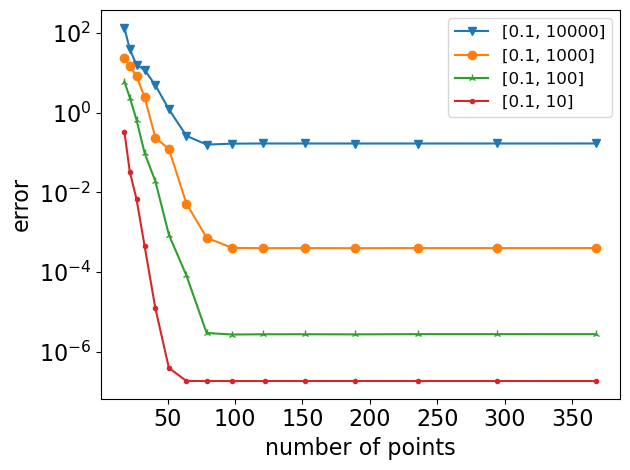

In [21]:
data_exp = data_pos_exp
#data_sinh = data_pos_sinh
figure, ax = plt.subplots()
markers1 = [".", ",", "o", "v", "^", "<", ">", "1", "2", "3"]
#plt.rcParams["font.size"] = 18
#plt.rcParams['font.family'] = 'Times New Roman'
plt.plot(data_exp[3, 0], data_exp[3,1], marker=markers1[3],label="[0.1, 10000]")
plt.plot(data_exp[2, 0], data_exp[2,1], marker=markers1[2],label="[0.1, 1000]")
plt.plot(data_exp[1, 0], data_exp[1,1], marker=markers1[-2],label="[0.1, 100]")
plt.plot(data_exp[0, 0], data_exp[0,1], marker=markers1[0],label="[0.1, 10]")

model1 = forcoef3(data_exp[0, 0][:8], data_exp[ 0, 1][:8])
model2 = forcoef3(data_exp[1, 0][:8], data_exp[ 1, 1][:8])
model3 = forcoef3(data_exp[2, 0][:8], data_exp[ 2, 1][:8])
model4 = forcoef3(data_exp[3, 0][:8], data_exp[ 3, 1][:8])
print(f"[0.1, 10]: {model1.coef_}, [0.1, 100]: {model2.coef_}, [0.1, 1000]: {model3.coef_}, [0.1, 10000]: {model4.coef_}")

#ax.plot(data[4, 0], data[4,1], marker=markers1[4],label="[0.1, 1e+5]")
#ax.plot(data[5, 0], data[5,1], marker=markers1[5],label="[0.1, 1e+6]")

#plt.set_xlabel("number of points")
#plt.set_ylabel("error")
plt.xlabel("number of points", fontsize = 16)
plt.ylabel("error", fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 12)
#ax.set_yscale("log")
plt.yscale("log")
plt.tight_layout()
#plt.savefig("thesis_data/pos_real_exp_min01_nega.eps", dpi=300)
plt.show()

In [22]:
#負の固有値を含む
#最大固有値10に固定 最大固有値を変えていく (1e+1, 1e+2, ...,1e+6)
#半無限区間

size = 100
rec = 5


endpoint = 1
emax = 10

mat_cls = matrix_cls.Make_matrix2(size=size, mattype="normal")
step_num = 15

#rec回分の標本点数と誤差がstep_num回分入った配列
data_pos_exp = np.zeros((rec, 2, step_num))

x_rng = np.random.default_rng(1)
X = x_rng.random((size, size))
Xinv = np.linalg.inv(X)

I = np.eye(size)
for i in range(rec):
    emin = 10**(-endpoint)
    a = np.zeros((size, size))
    a[0, 0] = emax 
    a[1, 1] = -emin 
    a_rng = np.random.default_rng(i+20)
    for j in range(size - 2):
        flag_ = 1.0
        if np.random.rand() < 0.5:
            flag_ = -1.0
        a[j+2, j+2] = ((emax - emin)*a_rng.random() + emin )*flag_
    
    A = X@a@Xinv
    A2 = A@A 
    sign_de = sign_de_class.DEformula_calculator(A)
    def_ans = sign_de.solve_ans()
    points_exp = sign_de.solve_step(step_num=step_num, def_ans=def_ans, h=0.5, method="1", h_delta=0.8)
    data_pos_exp[i, 0] = np.array([l[1][-1] for l in points_exp])
    data_pos_exp[i, 1] = np.array([l[-1] for l in points_exp])
    #print([l[1][:] for l in points])
    endpoint +=1

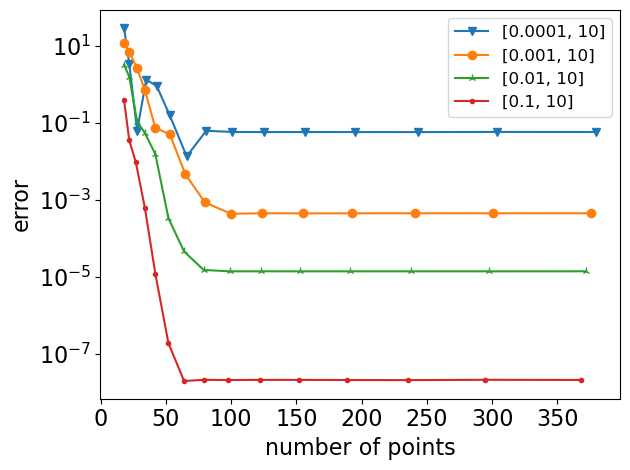

In [23]:
data_exp = data_pos_exp
#data_sinh = data_pos_sinh
figure, ax = plt.subplots()
markers1 = [".", ",", "o", "v", "^", "<", ">", "1", "2", "3"]
#plt.rcParams["font.size"] = 18
#plt.rcParams['font.family'] = 'Times New Roman'
plt.plot(data_exp[3, 0], data_exp[3,1], marker=markers1[3],label="[0.0001, 10]")
plt.plot(data_exp[2, 0], data_exp[2,1], marker=markers1[2],label="[0.001, 10]")
plt.plot(data_exp[1, 0], data_exp[1,1], marker=markers1[-2],label="[0.01, 10]")
plt.plot(data_exp[0, 0], data_exp[0,1], marker=markers1[0],label="[0.1, 10]")

"""
model1 = forcoef3(data_exp[0, 0][:8], data_exp[ 0, 1][:8])
model2 = forcoef3(data_exp[1, 0][:8], data_exp[ 1, 1][:8])
model3 = forcoef3(data_exp[2, 0][:8], data_exp[ 2, 1][:8])
model4 = forcoef3(data_exp[3, 0][:8], data_exp[ 3, 1][:8])
print(f"[0.1, 10]: {model1.coef_}, [0.1, 100]: {model2.coef_}, [0.1, 1000]: {model3.coef_}, [0.1, 10000]: {model4.coef_}")
"""
#ax.plot(data[4, 0], data[4,1], marker=markers1[4],label="[0.1, 1e+5]")
#ax.plot(data[5, 0], data[5,1], marker=markers1[5],label="[0.1, 1e+6]")

#plt.set_xlabel("number of points")
#plt.set_ylabel("error")
plt.xlabel("number of points", fontsize = 16)
plt.ylabel("error", fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 12)
#ax.set_yscale("log")
plt.yscale("log")
plt.tight_layout()
#plt.savefig("thesis_data/pos_real_exp_max10_nega.eps", dpi=300)
plt.show()